In [1]:
from matplotlib import pyplot as plt

import numpy as np
import cv2 as cv


In [2]:
filename = './videos/gray/news.avi'

In [3]:
def diff_pixels(frames, params):
    difference = np.abs(frames[1:] - frames[:-1])
    metrics = []

    for diff in difference:
        metrics.append(np.where(diff > params[0], 1, 0).sum())

    return metrics


In [4]:
def diff_blocks(frames, params):
    rows, cols = frames.shape[2], frames.shape[2]

    trows = rows // params[0]
    tcols = cols // params[0]

    frames = frames[:, :trows * params[0], :tcols * params[0]]
    difference = np.abs(frames[1:] - frames[:-1])
    difference = difference * difference


    metrics = []
    for diff in difference:
        count = 0
        blocks = diff.reshape(-1, tcols, params[0]).transpose(1,0, 2).reshape(-1, params[1])
        for block in blocks:
            root = np.sqrt(block.sum())
            if root > params[2]:
                count += 1
        metrics.append(count)
    return metrics


In [5]:
def get_metrics(file, shots_size, difference, params, dtype='int16'):
    cap = cv.VideoCapture(file)

    cols = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    rows = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

    shots = np.empty((shots_size + 1, rows, cols), dtype)
    metrics = []

    ret, frame = cap.read()
    first_frame = frame[:,:,0]
    count = 1

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            gray_frame = frame[:,:,0]
            if count > shots_size:
                shots[0] = first_frame
                first_frame = shots[-1].copy()

                # process shots
                metrics += difference(shots, params)

                shots[1] = gray_frame
                count = 2
            else:
                shots[count] = gray_frame
                count += 1
        else:
            # process shots[:count,:,:]
            shots[0] = first_frame
            metrics += difference(shots[:count, :, :], params)
            cap.release()
            break

    return metrics


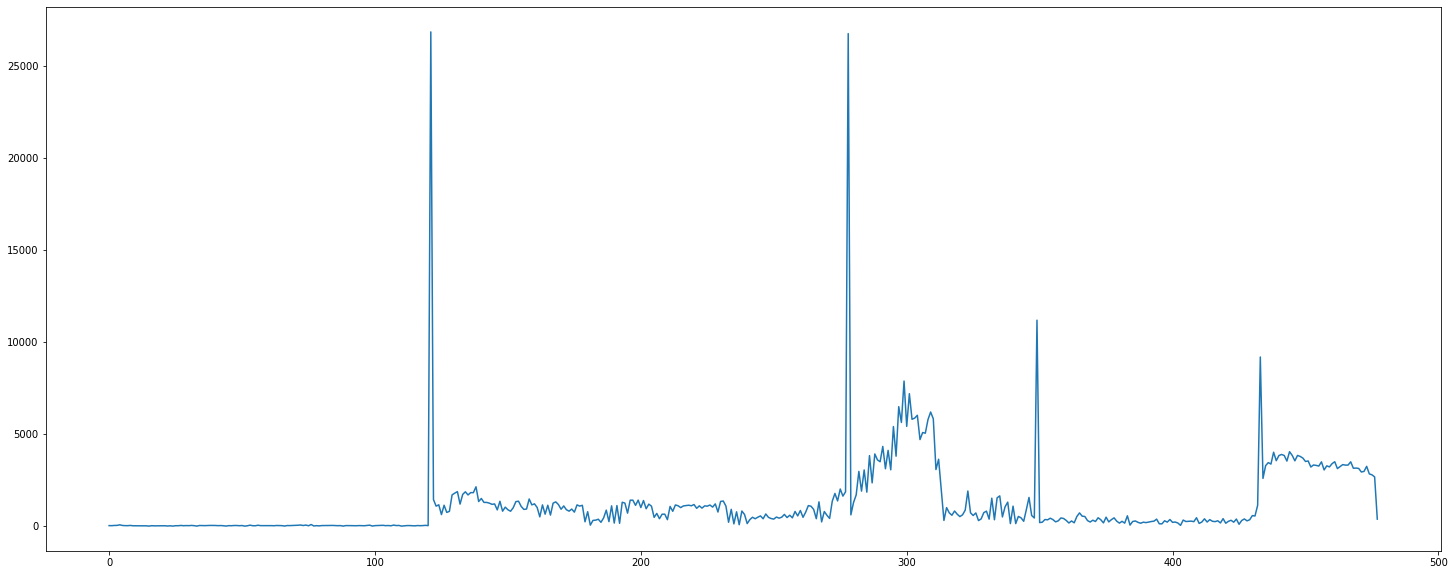

In [6]:
Y = np.array(get_metrics(filename, 512, diff_pixels, [128]))
X = range(len(Y))

plt.figure(figsize=(25,10))
plt.plot(X, Y)

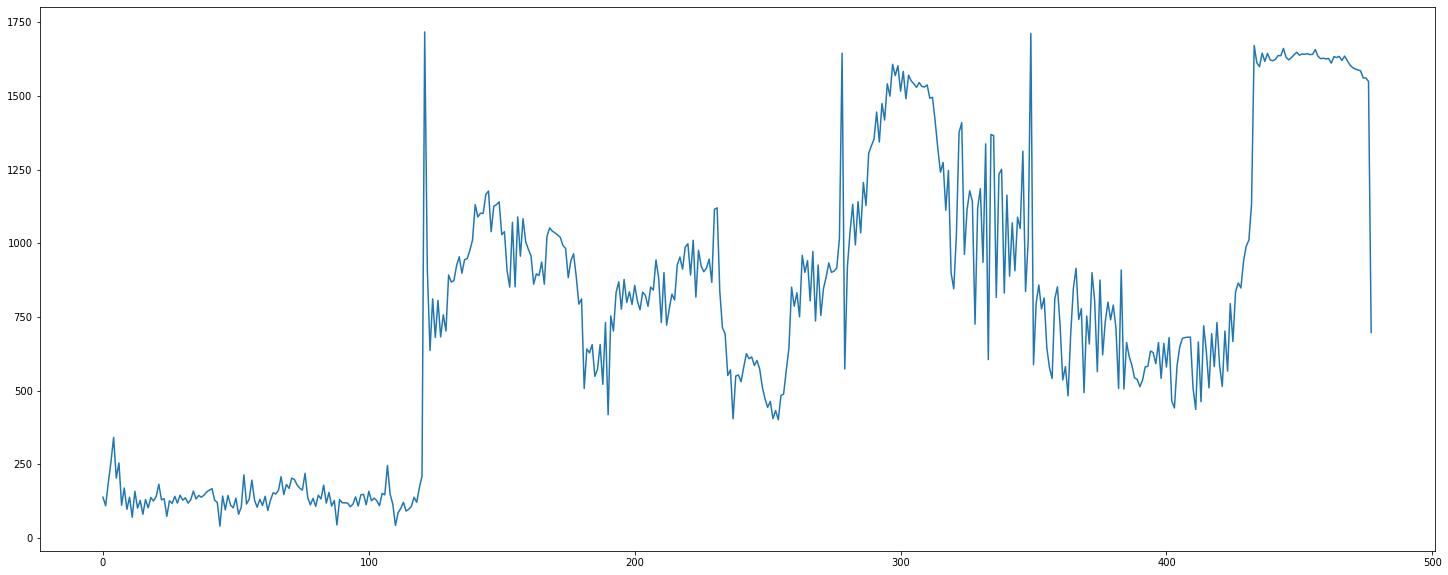

In [7]:
Y = np.array(get_metrics(filename, 512, diff_blocks, [8, 64, 128], 'int32'))
X = range(len(Y))

plt.figure(figsize=(25, 10))
plt.plot(X, Y)
